In [5]:
import glob
import scipy
import random
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import chisquare
from natsort import natsorted
from scipy.stats import describe
from scipy.signal import filtfilt

In [6]:
path = '/Users/patrick/Documents/phd/GitHub/thesis/figures/chapter_4/invsweep/L2_1e8/'

In [18]:
g4iso_files = natsorted(glob.glob(path+"*.csv"))
nmse_L2_1e8 = []
kappa_L2_1e8 = []

for i in range(1,len(g4iso_files)-1,1): 
    nmse_L2_1e8.append(np.loadtxt(open(g4iso_files[i], "r"), delimiter=",",skiprows=1)[:,0])


In [25]:
[item for sublist in t for item in sublist]

array([array([ 2.01908432,  1.1519241 ,  2.5310598 ,  0.55913963,  0.97547909,
               1.3954742 ,  3.07518637,  4.65329458,  0.62209376, 49.76973238,
               0.55721264,  1.54912952, 15.05369532,  5.18400114,  0.94454511,
               1.48878151,  1.78080427,  0.90246003,  4.23967596, 12.21475167,
               2.07557049,  1.58176733,  3.0957852 ,  0.35726026,  0.92882061,
              39.2243356 ,  1.06210518,  0.62584405, 22.09280514,  0.62881919,
              12.26847985,  2.32981856,  0.61566038,  0.72642849,  1.00100176,
               1.72149808,  1.97283877,  0.87032532,  3.77558209,  4.09485274,
               2.13163898,  1.94051451,  0.63128254,  0.47839743, 25.3208877 ,
               1.14051334,  0.84474581,  0.40897668,  2.58640093,  5.7192121 ,
               1.28972595,  0.30325082,  0.32173187,  0.86222971,  1.24105105,
               3.98691974,  2.06741002,  1.04422866,  7.03698154,  8.63668632,
               0.61408556,  0.79498604,  1.52167582,

In [4]:
# generate synthetic data 

e0 = np.linspace(30, 299, R.shape[0])
e1 = np.linspace(100, ehigh_keV, R.shape[1])

def bg(total):
    beam = np.full(len(espace), 0)
    signal = np.full(len(xspace), 0)
    for e in range(0, e0.shape[0]): # normally distributed noise
        signal[e] = abs(signal[e] + np.random.normal(signal[e],np.sqrt(total/len(espace))))
    return((signal,beam))

def ex(fold, elow, ehigh, total):
    beam = np.exp(-e1/fold)
    beam[0:(np.abs(e1 - elow)).argmin()] = 0.0
    beam[(np.abs(e1 - ehigh)).argmin():-1] = 0.0
    integral = np.trapz(beam,e1)
    beam = beam*total/integral # beam should integrate to total e-/cm^2/s
    
    signal = np.matmul(R,beam)
    
    for e in range(0, e0.shape[0]):
        signal[e] = abs(signal[e] + np.random.normal(signal[e],np.sqrt(signal[e])))
        
    return(signal,beam)

def gauss(mu, sig, elow, ehigh, total):
    beam = total*np.exp(-np.power(e1 - mu, 2.) / (2 * np.power(sig, 2.)))
    beam[0:(np.abs(e1 - elow)).argmin()] = 0.0 # low and high energy cutoffs
    beam[(np.abs(e1 - ehigh)).argmin():-1] = 0.0
    integral = np.trapz(beam, x=e1)
    beam = beam*total/integral # beam should integrate to total e-/cm^2/s
    signal = np.matmul(R,beam)
    for e in range(0, e0.shape[0]): 
        signal[e] = np.random.normal(signal[e], scale=np.sqrt(signal[e]))
    return(signal,beam)

def mono(e, total):
    beam = np.full(e1.shape[0], 0.0)
    beam[(np.abs(e1 - e)).argmin()] = total
    signal = np.matmul(R,beam) # beam should integrate to total e-/cm^2/s
    for e in range(0, e0.shape[0]): 
        signal[e] = np.random.normal(signal[e], scale=np.sqrt(signal[e]))
    return((signal,beam))


In [5]:
L0 = np.identity(R.shape[1])       # zeroth-order

L1 = np.copy(L0) 
for i in range(0, R.shape[1] - 1): # first-order
    L1[i,i+1] = -1.0

L2 = np.copy(L0)
for i in range(1, R.shape[1]-1): # second-order
    L2[i,i] = -2.0
    L2[i,i+1] = 1.0 
    L2[i,i-1] = 1.0
L2[-1,-2] = 0
L2[0,0] = 1
L2[0,1] = 0

def tk(R, op, kappa, xs, posonly):
    C = np.matmul(np.transpose(R),R) + (kappa**2)*np.matmul(np.transpose(op),op)
    D = np.matmul(np.transpose(R), xs)
    if (posonly):
        sol = scipy.optimize.nnls(C,D,maxiter=1e10)[0]
    else:
        sol = np.linalg.solve(C,D)
    error = (np.linalg.norm(np.matmul(R,sol) - xs))
    bias = np.linalg.norm((1)*np.matmul(op,sol))
    return(sol/2.0,error,bias)

def tks(R, op, kappa, xs, posonly):
    eq = lambda e: np.linalg.norm(np.matmul(R,e) - xs) + kappa*np.linalg.norm(np.matmul(op,e))
    bnds=scipy.optimize.Bounds(np.full(R.shape[1],0), np.full(R.shape[1],np.inf))
    sol = scipy.optimize.minimize(eq,tk(R,op,kappa,xs,True)[0],options={"maxiter":1e40},bounds=bnds)
    return(sol.x)

In [6]:
# cross validation

def cv(R, op, kappas, xs, posonly):
    err = []
    for kappa in kappas:
        e = 0
        for i in range(0, len(xs) - 1):
            RST = np.delete(RS,i,0)
            xst = np.delete(xs,i,0) # delete one X-ray data point and solve the reduced problem
            sol = np.matmul(tk(RST, op, kappa, xst, posonly)[0],SS)
            e += (np.matmul(RT,sol)[i] - xs[i])**2
        err.append(e)
    return(err)

In [7]:
def nmse(actual,predicted): # normalized mean-squared error 
    error = actual - predicted
    return(np.dot(np.transpose(error),error)/np.dot(np.transpose(actual),actual))

In [9]:
# generate a set of training data that spans many test cases
# we expect generally smooth functions over our energy range, but have no prior information on the shape, or on the total
# fluxes.

def make_random_spectrum(omega,total):
    fold = random.randrange(1,30,1)
    omega = random.randrange(0,10,1)/10.0
    weights = np.exp(-np.array(range(0,espace.shape[0]))/fold)
    bins = []
    for i in range(0,espace.shape[0]):
        bins.append(random.randrange(0,1000,1))
    b, a = scipy.signal.butter(1, omega, 'low')
    o = filtfilt(b, a, bins ,axis=0)
    
    integral = np.trapz(o,e1)
    beam = o*total/integral # beam should integrate to total e-/cm^2/s
    
    signal = np.matmul(R,beam)
    
    for e in range(0, e0.shape[0]): # add normally distributed noise
            signal[e] = abs(signal[e] + np.random.normal(signal[e],np.sqrt(signal[e])))
        
    return((signal,beam))

Normalized mean squared error: 0.6836255312347225
Kappa estimated: 9.102981779915218


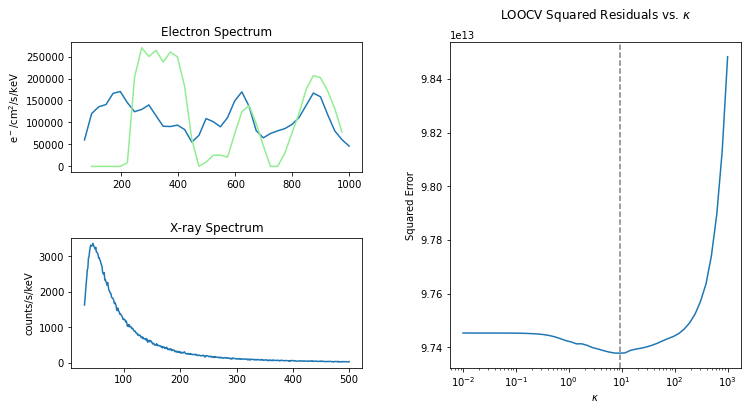

In [18]:
beam = make_random_spectrum(.8,1e8)
beamx = np.matmul(np.diag(D),beam[0])

fig = plt.figure(figsize=(12,6))
gs = plt.GridSpec(nrows=2, ncols=2,hspace=.5,wspace=.3)

ax1 = fig.add_subplot(gs[1,0])
ax2 = fig.add_subplot(gs[0,0])
ax3 = fig.add_subplot(gs[:,1])

ax1.set_title('X-ray Spectrum')
ax1.set_ylabel('counts/s/keV')
ax2.set_ylabel('$\mathrm{e^-}/\mathrm{cm}^2/\mathrm{s}/\mathrm{keV}$')
ax2.set_title('Electron Spectrum')
ax3.set_title('LOOCV Squared Residuals vs. $\kappa$\n')
ax3.set_xlabel('$\kappa$')
ax3.set_ylabel('Squared Error')


ss = np.logspace(-2,3,50)
e = cv(R, L2, ss, beamx, True)
sol = np.matmul(tk(RS, L2, ss[np.argmin(e)], beamx, True)[0],SS)
ax1.plot(xspace,beam[0])
ax2.plot(espace, beam[1],label='assumed')
ax2.plot(espace[1:-1], sol[1:-1],label='model',color='lightgreen')
ax3.semilogx(ss,e)
print('Normalized mean squared error: ' + str(nmse(beam[1][1:-1],sol[1:-1])))
print('Kappa estimated: ' + str(ss[np.argmin(e)]))

ax3.axvline(x=ss[np.argmin(e)],color='grey',linestyle='dashed')


In [179]:
from IPython.display import clear_output

nmses = []
kappas = []

for i in range(1,1000):
    try:
        clear_output(wait=True)
        print('iteration: ' + str(i) )
        
        beam = make_random_spectrum(.8,1e7)
        beamx = np.matmul(np.diag(D),beam[0])
        ss = np.logspace(-5,5,20)
        e = cv(R, L2, ss, beamx, True)
        sol = np.matmul(tk(RS, L2, ss[np.argmin(e)], beamx, True)[0],SS)
        nmses.append(nmse(beam[1],sol))
        kappas.append(ss[np.argmin(e)])
    except ValueError as e:
        continue

iteration: 999


(array([483., 154.,  82.,  54.,  28.,  28.,  13.,  13.,  13.,   5.,   4.,
          7.,   5.,   7.,   6.,   3.,   6.,   5.,   4.,   2.,   1.,   2.,
          1.,   1.,   5.,   0.,   3.,   2.,   1.,   0.,   2.,   1.,   1.,
          0.,   2.,   1.,   0.,   2.,   0.,   0.,   0.,   0.,   2.,   1.,
          1.,   1.,   2.,   0.,   0.,   0.,   0.,   0.,   1.,   0.,   0.,
          0.,   0.,   1.,   1.,   1.,   1.,   0.,   0.,   0.,   0.,   0.,
          0.,   1.,   0.,   2.,   1.,   0.,   0.,   0.,   1.,   0.,   1.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   1.,   0.,   0.,   0.,
          0.,   0.,   0.,   1.,   0.,   0.,   0.,   0.,   0.,   0.,   1.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0., 

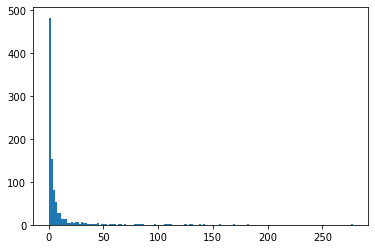

In [184]:
plt.hist(nmses,bins=150)

0.6

In [25]:
random.randrange(1,10000,1)

4359